# MNIST를 활용한 딥러닝 실습

- 이미지 학습시킬때 → 배치단위로 쪼개서 넣음
- 이미지 : [3, 128, 128] → 3차원
- ->(배치단위로 쪼갬) [10, 3, 128, 128] → 4차원
- -> 차원을 맞춰줘야함!!!

- pyTorch : 비전쪽에 특화됨 (이미지 분류, ...)
- torchvision.transforms : 이미지 전처리 라이브러리
- 이미지 전처리란? 사이즈를 맞추는것
- DataLoader : 데이터를 불러와서 쪼개주는 역할 (= train_test_split)

In [3]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch
import torch.nn as nn
from torch.optim.adam import Adam

## 손글씨 데이터를 이용한 이미지 분류

In [4]:
# 이미지를 전처리 하는 방법이 1) torchvision.transforms 가 있고, 데이터 불러올때, 2) 'transform=' 형태로 전처리 가능
# transform=ToTensor() : pyTorch가 읽기 좋게 tensor 형태로 가져와라
train_data = MNIST(root="./", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./", train=False, download=True, transform=ToTensor())

In [5]:
train_data.data.size()
# torch.Size([60000, 28, 28]) : 데이터 개수 : 6만개 / 이미지는 3차원이므로, 4개의 값이 나와야하는데 값이 3개 밖에 없음 -> 흑백 이미지임

torch.Size([60000, 28, 28])

In [6]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [7]:
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

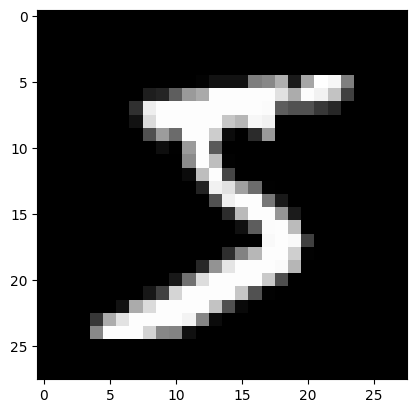

In [8]:
# 그려서 직접 확인해보자
plt.imshow(train_data.data[0], cmap='gray')     # 흑백이미지 cmap='gray'
plt.show()

## 미니배치

In [9]:
# DataLoader : 총 6만개의 데이터를 32개씩 1875개의 묶음으로 나눠주는 역할
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)      # shuffle = random_state
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)       # shuffle 상관없음

In [10]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = nn.Sequential(                      # 실제로는 이렇게 안함 -> 클래스로함
    nn.Linear(784, 64),                     # 784 : 28*28 / 64개는 내가 정한 output 개수
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10)                       # 10개의 카테고리로 분류 -> 최종 output:10
)

model.to(device)
model

# 모델을 gpu로 보냄 -> 뭘 저장하기 위함일까
# 모델의 가중치들을 학습시킴 -> 저장

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
from tensorboardX import SummaryWriter

In [ ]:
writer = SummaryWriter()

lr = 1e-3
criterion = nn.CrossEntropyLoss()               # CrossEntropyLoss() 쓴 이유 : 분류
optim = Adam(model.parameters(), lr=lr)         # parameters() : Adam이 최적화시키는 것은 모델의 가중치, param=가중치
epochs = 20
step = 0

for epoch in range(20) :
    for data, label in train_loader :           # train_loader -> [(데이터1, 정답1), (데이터2, 정답2), ...]
        optim.zero_grad()
        data = torch.reshape(data, (-1, 784))   # 모델 입력데이터 : 784개의 1차원 / 데이터 -> 3차원의 데이터를 1차원으로 바꿔 사용해야함
        # data = data.view(-1, 784)             # 3차원 -> 1차원 : reshape() or view()
        pred = model(data.to(device))
        loss = criterion(pred, label.to(device))
        writer.add_scalar("Loss/train", loss.item(), step)  # (그래프이름, x축(손실값), y축(step : 한번 학습할때마다 +1))
        step = step + 1
        loss.backward()
        optim.step()                            # 가중치 업데이트
    
    print(f"{epoch+1} loss ::: {loss.item()}")

1 loss ::: 0.1292235553264618
2 loss ::: 0.08665318787097931
3 loss ::: 0.3006584644317627
4 loss ::: 0.1392887532711029
5 loss ::: 0.008286639116704464
6 loss ::: 0.006662772968411446
7 loss ::: 0.0141095956787467
8 loss ::: 0.010491662658751011
9 loss ::: 0.004578251391649246
10 loss ::: 0.001400831970386207
11 loss ::: 0.001378377666696906
12 loss ::: 0.012766620144248009
13 loss ::: 0.00965967494994402
14 loss ::: 0.0843205451965332
15 loss ::: 0.0032520759850740433
16 loss ::: 2.883059460145887e-05
17 loss ::: 0.00024395788204856217
18 loss ::: 0.0043088458478450775
19 loss ::: 0.0007139212684705853
20 loss ::: 0.0759950503706932


```
uv add tensorboard
uv add tensorboardX
```
- tensorboardX 는 코드에서 로그 기록 (PyTorch) - SummaryWriter 클래스 제공
- tensorboard 는 로그 시각화 실행

```
uv run tensorboard --logdir=runs
```
- http://localhost:6006/ 로 들어가서 그래프 확인

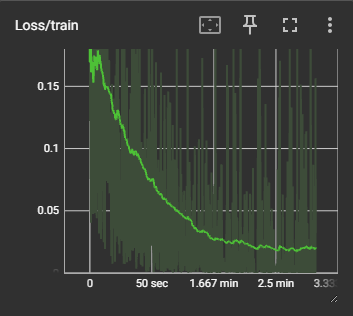

In [ ]:
# 평가 -> 가중치 값들 고정됨
# model.eval() -> 위에서 학습된 모델을 테스트모델로 바꾸겠다 - 추론형 모델로
model.eval()

with torch.no_grad() :        # no_grad() : 자동미분 끔
    total_corr = 0
    for images, labels in test_loader :
        # print(images.shape)
        images = images.view(-1, 784).to(device)                    # 모델의 input 값이 784 이므로 데이터도 똑같이 넣어줘야함
        labels = labels.to(device)

        preds = model(images)

        _, pred = torch.max(preds.data, 1)                          # torch.max() -> 결과값 : (max_values(최대값), max_indices(인덱스))
        total_corr = total_corr + (pred == labels).sum().item()     # 정답만 저장 -> 전체데이터 개수로 나누면 정답률 나옴

print(f"정확도 : {total_corr/len(test_data.targets)}")
        

정확도 : 0.9713


In [ ]:
preds

# [-2.8236e+01,  1.2910e+01, -1.4578e+01, -9.9309e+00, -6.7990e+00,
#  -2.5207e+01, -2.2819e+01,  7.5592e-01, -6.2279e+00, -1.6063e+01]
# 이렇게 정답이 10개가 나옴 (내가 설정해준 output값 :10)
# 이 중 제일 확률이 높은게 정답 (0~9번째 중 1번째가 확률이 젤 높음 -> 정답 : 1) -> torch.max()로 뽑아내자

tensor([[-2.8236e+01,  1.2910e+01, -1.4578e+01, -9.9309e+00, -6.7990e+00,
         -2.5207e+01, -2.2819e+01,  7.5592e-01, -6.2279e+00, -1.6063e+01],
        [-2.8751e+01, -5.0059e+00,  2.3244e+01,  8.8881e+00, -4.7431e+01,
         -2.0337e+01, -4.1224e+01,  4.0607e+00, -2.4734e+00, -2.4198e+01],
        [-5.0134e+01, -4.7426e-02, -1.2907e+01,  2.2526e+01, -4.4127e+01,
         -9.4241e+00, -6.3559e+01, -4.4259e+00, -8.5849e-01, -2.2632e+00],
        [-2.9836e+01, -1.2969e+01, -9.9849e+00, -2.4605e+01,  2.6724e+01,
         -1.4871e+01, -1.9631e+01, -1.6319e+01, -9.6948e+00, -8.3185e+00],
        [-3.3225e+01, -1.0403e+01, -4.2660e+01, -8.6162e+00, -2.0438e+01,
          3.2721e+01, -3.1578e+01, -1.9963e+01, -1.1249e+01, -3.7791e+00],
        [-1.1200e+01, -1.1664e+01, -1.3639e+01, -1.4544e+01, -9.4277e+00,
         -7.6460e-01,  2.3891e+01, -2.7436e+01, -6.5987e+00, -2.8651e+01],
        [-3.2820e+01, -4.2373e+00, -1.0487e+01,  2.2713e+00, -2.8919e+01,
         -4.2340e+01, -4.9660e+0

In [18]:
torch.max(preds.data, 1)

torch.return_types.max(
values=tensor([12.9105, 23.2442, 22.5263, 26.7237, 32.7215, 23.8910, 25.0100, 18.2333,
        17.6118, 22.8617, 13.3510, 23.8458, 21.3228, 26.0153, 23.2692, 25.3876],
       device='cuda:0'),
indices=tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0'))

In [ ]:
preds.data.shape

# 지금 보는건 반복문의 제일 마지막 shape -> 32개씩 묶어서 남은 개수 16개의 정답 10개

torch.Size([16, 10])

In [ ]:
# 모델 예측 정답 
_, pred = torch.max(preds.data, 1)
pred

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')

In [24]:
# 실제 정답
labels

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')

In [ ]:
# 모델 예측값과 실제정답 비교 (정답 -> True(=1))
pred == labels

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

In [ ]:
(pred == labels).sum()
# true 값이 16 -> 16개 중 16개 맞음

tensor(16, device='cuda:0')

In [ ]:
# 분류에서 자주 나타나는 문제
# 1. 데이터 불균형
# 2. 클래스 간 유사성 : 서로 유사한 클래스가 있어 모델이 혼동 (3 vs 8)